,Dataset,logits_Grag2021_progan,logits_Grag2021_latent,resnet50nodown_progan,resnet50nodown_stylegan2,aggregated_accuracy
0,dalle-2.csv,0.216,0.016,0.400,0.009,0.490
1,dalle-3.csv,0.041,0.716,0.014,0.007,0.716
2,hdr.csv,1.000,1.000,0.972,1.000,0.972
3,midjourney.csv,0.069,0.970,0.237,0.012,0.975
4,mscoco2014.csv,0.994,0.998,0.984,0.998,0.976
5,vqgan.csv,0.378,0.586,0.453,0.415,0.799


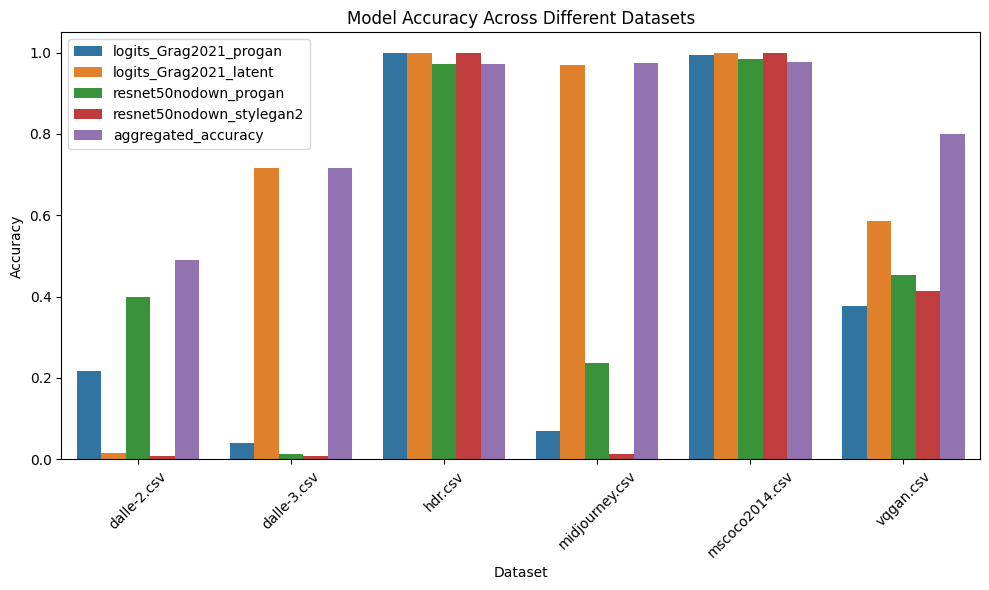

In [12]:
import pandas as pd
import os
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt
import seaborn as sns


# Directory path
directory = '../csv/'

threshold = 0.2

# Initialize an empty DataFrame for overall performance
overall_performance = pd.DataFrame()

# Mapping columns to their respective model names
model_columns = {
    'logits_Grag2021_progan': 'dMDetectorResultsinferenceResults_logits_Grag2021_progan',
    'logits_Grag2021_latent': 'dMDetectorResultsinferenceResults_logits_Grag2021_latent',
    'resnet50nodown_progan': 'gANDetectorResultsinferenceResults_logits_gandetection_resnet50nodown_progan',
    'resnet50nodown_stylegan2': 'gANDetectorResultsinferenceResults_logits_gandetection_resnet50nodown_stylegan2',
}

# Function to calculate model performance
def calculate_model_performance(df):
    # Converting logits to probabilities using sigmoid function
    for model, column in model_columns.items():
        df[model] = sigmoid(df[column])

    # Converting probabilities to binary predictions based on the threshold
    for model in model_columns:
        df[model] = (df[model] > threshold).astype(int)

    # Calculating accuracy for each model
    accuracies = {}
    true_label_col = 'true_label'
    for model in model_columns:
        accuracy = (df[model] == df[true_label_col]).mean()
        accuracies[model] = accuracy

    # Calculating aggregated accuracy
    df['aggregated_accuracy'] = df[list(model_columns)].max(axis=1)
    aggregated_accuracy = (df['aggregated_accuracy'] == df[true_label_col]).mean()
    accuracies['aggregated_accuracy'] = aggregated_accuracy

    return accuracies

# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        # Calculate the model performance
        model_performances = calculate_model_performance(df)
        # Store the results
        overall_performance = pd.concat([overall_performance, pd.DataFrame(model_performances, index=[filename])])

# Resetting index for better display
overall_performance.reset_index(inplace=True)
overall_performance.rename(columns={'index': 'Dataset'}, inplace=True)

display(overall_performance)

# Melting the dataframe for easier plotting
df_melted = overall_performance.melt(id_vars="Dataset", var_name="Model", value_name="Accuracy")

# Plotting bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x="Dataset", y="Accuracy", hue="Model", data=df_melted)

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Across Different Datasets')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()